In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
from librosa.core import resample, to_mono
import wavio
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from jupyterthemes import jtplot

!jt -t monokai -f fira -fs 13 -nf ptsans -nfs 11 -N -kl -cursw 5 -cursc r -cellw 60% -T

In [2]:
jtplot.style(theme='monokai', context='notebook', ticks=True, gridlines='--')

In [3]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    plt.show()

In [4]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    plt.show()

In [5]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    plt.show()

In [6]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    plt.show()

In [7]:
rootFolder = "bird_data"
wavFolder = os.path.join(rootFolder, "wav_files")
bird_calls_df = pd.read_csv(os.path.join(rootFolder, "bird_calls.csv"))

In [8]:
bird_calls_df.head()

,fname,label
0,American_Goldfinch_XC114342.wav,American_Goldfinch
1,American_Goldfinch_XC124312.wav,American_Goldfinch
2,American_Goldfinch_XC133564.wav,American_Goldfinch
3,American_Goldfinch_XC133565.wav,American_Goldfinch
4,American_Goldfinch_XC141469.wav,American_Goldfinch


# Class inbalance

In [9]:
bird_calls_df.set_index('fname', inplace=True)

In [10]:
# add column with the length of the signal in seconds
for f in bird_calls_df.index:
    rate, signal = wavfile.read(os.path.join(wavFolder,f))
    bird_calls_df.at[f, "length"] = signal.shape[0]/rate

In [11]:
bird_calls_df.head()

,label,length
fname,,
American_Goldfinch_XC114342.wav,American_Goldfinch,136.968375
American_Goldfinch_XC124312.wav,American_Goldfinch,52.920000
American_Goldfinch_XC133564.wav,American_Goldfinch,50.599184
American_Goldfinch_XC133565.wav,American_Goldfinch,55.222857
American_Goldfinch_XC141469.wav,American_Goldfinch,54.058934


In [13]:
bird_classes = list(np.unique(bird_calls_df.label))

In [14]:
bird_classes_distribution = bird_calls_df.groupby(['label'])['length'].mean()

In [15]:
bird_classes_distribution

label
American_Goldfinch        52.322228
American_Robin            75.790837
Barn_Swallow             132.134248
Blue-grey_Gnatcatcher     60.431434
Blue_Jay                  49.986092
Carolina_Chickadee        56.634403
Carolina_Wren             50.195712
Cedar_Waxwing             39.937296
Northern_Cardinal         66.524785
Ruby-crowned_Kinglet      52.924116
Name: length, dtype: float64

In [16]:
def hbarplot(data, xlabel, title):
    fig, ax = plt.subplots()
    ax.barh(data.index, data)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

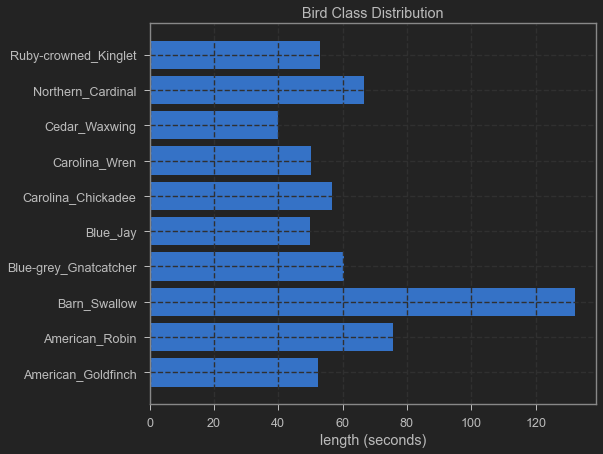

In [17]:
hbarplot(bird_classes_distribution, "length (seconds)", "Bird Class Distribution")

In [18]:
bird_calls_df.reset_index(inplace=True)
bird_calls_df.head()

,fname,label,length
0,American_Goldfinch_XC114342.wav,American_Goldfinch,136.968375
1,American_Goldfinch_XC124312.wav,American_Goldfinch,52.920000
2,American_Goldfinch_XC133564.wav,American_Goldfinch,50.599184
3,American_Goldfinch_XC133565.wav,American_Goldfinch,55.222857
4,American_Goldfinch_XC141469.wav,American_Goldfinch,54.058934


In [19]:
# Fast Fourier Function calculator (magnitude and frequency of the signal)
def cal_fft(y, rate):
    n=len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    # magnitude of the signal, normalize by the length of the signal
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)
    

In [20]:
# Clean signal by a noise threshold 
def denoise(y, rate,threshold):
    y = pd.Series(y).apply(np.abs)
    envelope = []
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for m in y_mean:
        if m>threshold:
            envelope.append(True)
        else:
            envelope.append(False)
    return envelope

In [21]:
# Spectral Features
def spectralFeatures(df, N_FFT, N_MELS, SR):
    hop = N_FFT
    classes = list(np.unique(df.label))
    signals = {}
    fft = {}
    fbank = {}
    mfccs = {}
    mels = {}
    for c in classes:
        wav_file = df[df.label == c].iloc[0,0]
        signal, rate = librosa.load(os.path.join(wavFolder, wav_file), sr=SR)
        # Raw signal
        signals[c] = signal
        # Fast Fourier Transform
        fft[c] = cal_fft(signal, rate)
        # Log Filterbank Energies
        bank = logfbank(signal[:rate], rate, nfilt=26, nfft=N_FFT).T
        fbank[c] = bank
        # Mel Frequency Cepstrum Coefficients
#         coefficients = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
        coefficients = librosa.feature.mfcc(y=signal[:rate], sr=rate, n_fft = N_FFT, n_mels=N_MELS, hop_length = hop, htk=True, 
                                            fmin=1400, fmax = rate/2)
        mfccs[c]=coefficients
        # Mel Scaled Spectrogram
#         mel = librosa.feature.melspectrogram(y=signal[:rate], sr=rate,n_fft =n_fft, n_mels = n_mels, hop_length=160, center=True)
        
        
        
    return signals, fft, fbank, mfccs
    


In [22]:
s, f, b, m = spectralFeatures(bird_calls_df, 1024, 128, 22050)

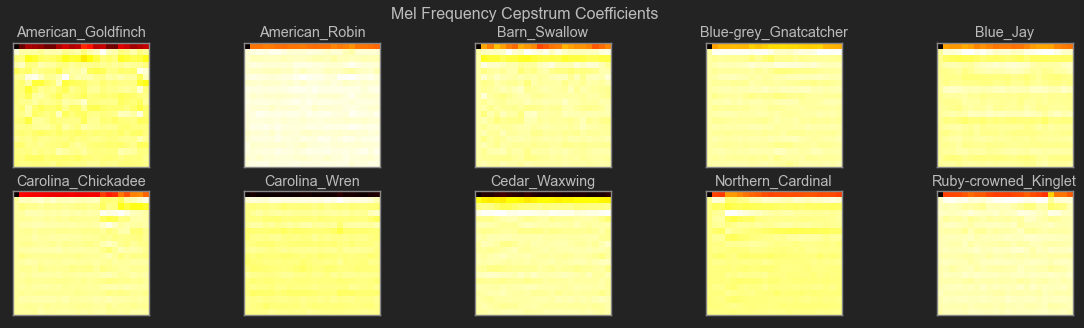

In [23]:
plot_mfccs(m)

In [24]:
one=m['American_Goldfinch'][0]
one

array([-588.0115 , -492.26978, -423.6259 , -435.07687, -447.45306,
       -485.1905 , -485.3844 , -421.6725 , -386.38535, -421.0107 ,
       -404.74225, -302.55   , -323.6493 , -407.88358, -396.90326,
       -479.66818, -483.83667, -370.32776, -391.70578, -437.82224,
       -417.5866 , -399.60522], dtype=float32)

plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(one**2,ref=np.max), fmin=1400,y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [26]:
signals = {}
fft = {}
fbank = {}
mfccs = {}
for b in bird_classes:
    wav_file=bird_calls_df[bird_calls_df.label == b].iloc[0,0]
    print(wav_file)
    signal, rate = librosa.load(os.path.join(wavFolder, wav_file), sr=44100)
    signals[b] = signal
    fft[b] = cal_fft(signal, rate)
    # filterbank energies
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[b] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[b]=mel
    

American_Goldfinch_XC114342.wav
American_Robin_XC112597.wav
Barn_Swallow_XC113501.wav
Blue-grey_Gnatcatcher_XC130506.wav
Blue_Jay_XC110056.wav
Carolina_Chickadee_XC111140.wav
Carolina_Wren_XC112512.wav
Cedar_Waxwing_XC121795.wav
Northern_Cardinal_XC110059.wav
Ruby-crowned_Kinglet_XC131366.wav


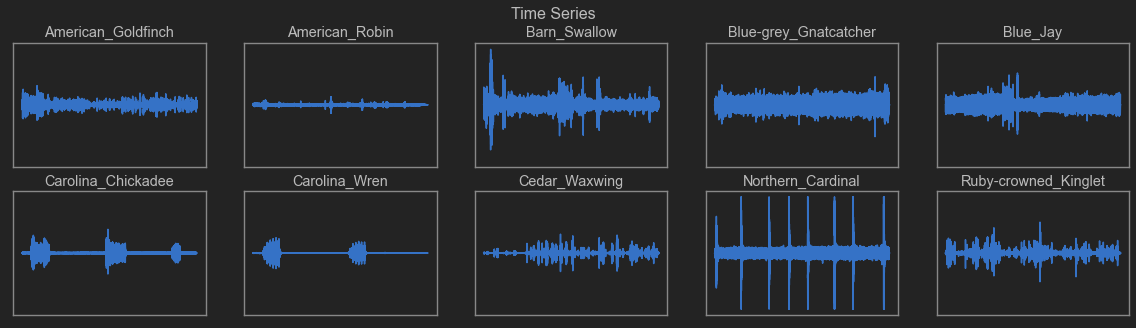

In [109]:
plot_signals(signals)

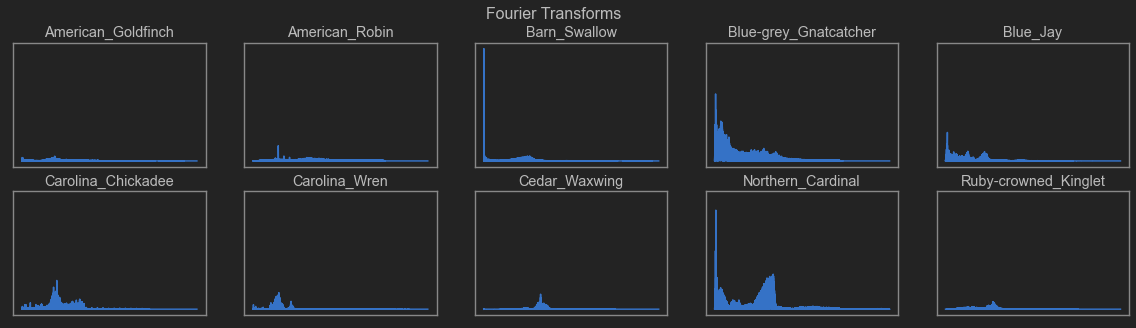

In [72]:
plot_fft(fft)

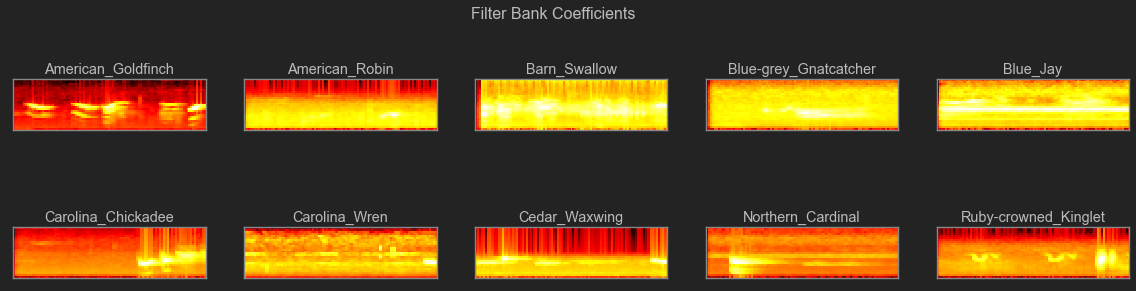

In [73]:
plot_fbank(fbank)

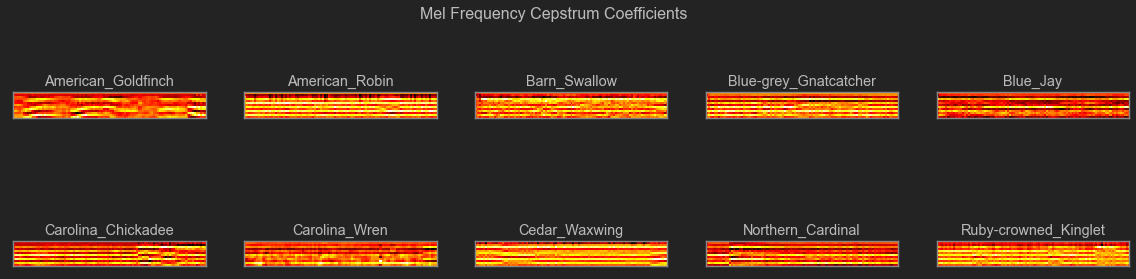

In [74]:
plot_mfccs(mfccs)

## Cleaning the signals. Noise threshold.

### Denoised signals

In [26]:
signals2 = {}
fft2 = {}
fbank2 = {}
mfccs2 = {}
for b in bird_classes:
    wav_file=bird_calls_df[bird_calls_df.label == b].iloc[0,0]
    signal, rate = librosa.load(os.path.join(wavFolder, wav_file), sr=44100)
    envelope = denoise(signal, rate, 0.0005)
    signal = signal[envelope]
    signals2[b] = signal
    fft2[b] = cal_fft(signal, rate)
    # filterbank energies
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank2[b] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs2[b]=mel

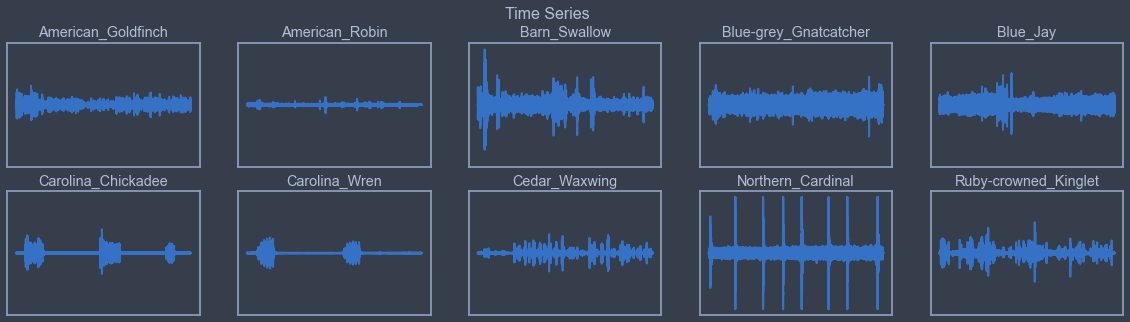

In [28]:
plot_signals(signals2)

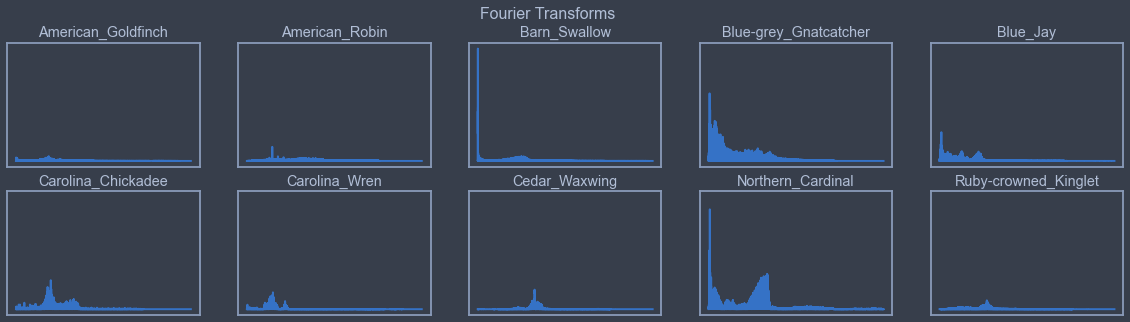

In [29]:
plot_fft(fft2)

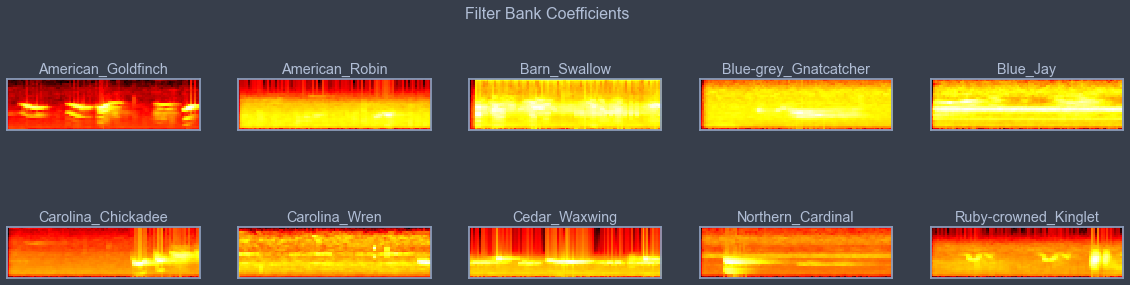

In [30]:
plot_fbank(fbank2)

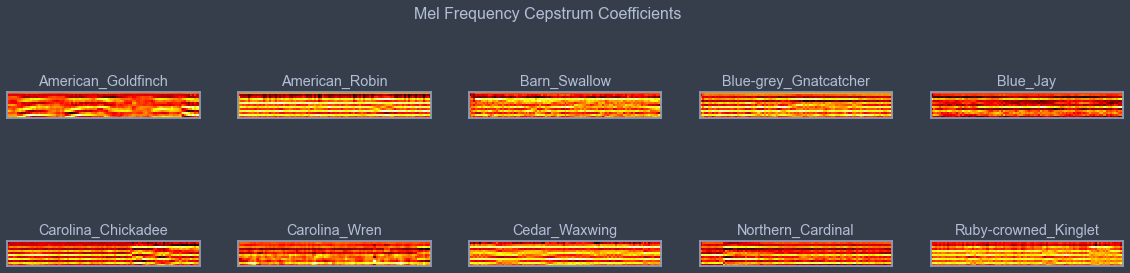

In [31]:
plot_mfccs(mfccs2)

# use librosa for the Filter bank construction

In [95]:
mfccsL = {}
melL = {}
for b in bird_classes:
    wav_file=bird_calls_df[bird_calls_df.label == b].iloc[0,0]
    signal, rate = librosa.load(os.path.join(wavFolder, wav_file), sr=44100)
    coef = librosa.feature.mfcc(y=signal[:rate], sr=rate, n_mfcc=13, n_fft=1103, n_mels=26, htk=False)
    mfccsL[b]=coef
#     mel = librosa.feature.melspectrogram(y=signal[:rate], sr=rate, n_fft=1103, n_mels=26, hop_length=160, center=True)
#     melL[b]=mel

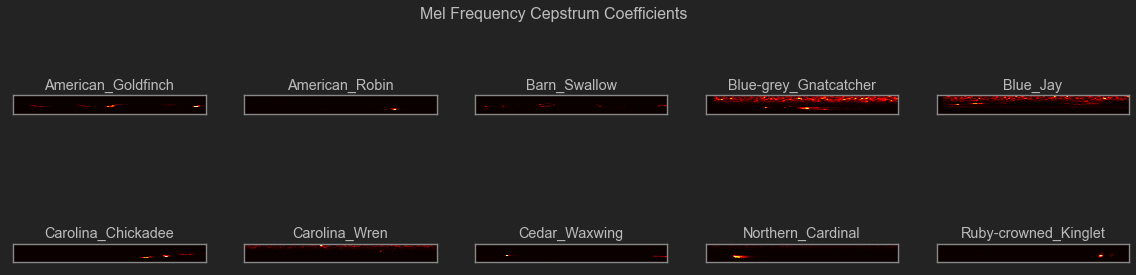

In [96]:
plot_mfccs(melL)